In [ ]:
import os
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip
from astropy.convolution import convolve, Gaussian2DKernel
from photutils import Background2D, MedianBackground, detect_threshold, detect_sources
from reproject import reproject_interp
from scipy.ndimage import median_filter, rotate, shift, zoom
import random
import matplotlib.pyplot as plt

# Utility functions for file operations
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def load_fits(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def save_fits(data, header, file_path):
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto(file_path, overwrite=True)

# Step 2: Image Alignment
# This function aligns the input image to a reference image using their WCS information.
# It ensures all images cover the same field of view and have consistent pixel scales.
def align_images(reference_image, image_to_align):
    ref_data, ref_header = load_fits(reference_image)
    data, header = load_fits(image_to_align)
    
    ref_wcs = WCS(ref_header)
    aligned_data, footprint = reproject_interp((data, header), ref_wcs, ref_data.shape)
    
    return aligned_data, ref_header

# Step 3: Background Subtraction
# This function estimates and subtracts the background from the image.
# It helps isolate the galaxies from the sky background for better analysis.
def subtract_background(image_data):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image_data, (50, 50), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    return image_data - bkg.background

# Step 4: Noise Reduction
# This function applies a median filter to reduce noise in the image.
# It helps improve image quality by smoothing out random fluctuations.
def reduce_noise(image_data, filter_size=3):
    return median_filter(image_data, size=filter_size)

# Step 5: PSF Matching (if needed)
# This function matches the Point Spread Function of the image to a target FWHM.
# It ensures consistent resolution across different filters and instruments.
def match_psf(image_data, target_fwhm, current_fwhm):
    kernel_sigma = np.sqrt(target_fwhm**2 - current_fwhm**2) / (2 * np.sqrt(2 * np.log(2)))
    kernel = Gaussian2DKernel(kernel_sigma)
    return convolve(image_data, kernel)

# Step 7: Create Multi-band Images
# This function creates a color image from three input images (RGB).
# It helps visualize the galaxy features across different wavelengths.
def create_color_image(red_image, green_image, blue_image):
    r = (red_image - np.min(red_image)) / (np.max(red_image) - np.min(red_image))
    g = (green_image - np.min(green_image)) / (np.max(green_image) - np.min(green_image))
    b = (blue_image - np.min(blue_image)) / (np.max(blue_image) - np.min(blue_image))
    return np.dstack((r, g, b))

# Step 8: Segmentation (if needed)
# This function detects and segments individual sources in the image.
# It can be used to isolate individual galaxies for separate analysis.
def segment_galaxies(image_data, nsigma=2.0, npixels=5):
    threshold = detect_threshold(image_data, nsigma=nsigma)
    return detect_sources(image_data, threshold, npixels=npixels)

# Step 10: Data Augmentation
# This function applies various augmentations to the input image.
# It helps increase the diversity of the dataset for machine learning purposes.
def augment_image(image):
    augmentations = [
        lambda img: rotate(img, random.uniform(-10, 10), reshape=False, mode='nearest'),
        lambda img: np.fliplr(img) if random.choice([True, False]) else np.flipud(img),
        lambda img: shift(img, (random.uniform(-5, 5), random.uniform(-5, 5)), mode='nearest'),
        lambda img: zoom(img, random.uniform(0.9, 1.1), order=1),
        lambda img: np.clip(img * random.uniform(0.9, 1.1), 0, np.max(img))
    ]
    
    for _ in range(random.randint(1, 3)):
        aug = random.choice(augmentations)
        image = aug(image)
    
    return image

# Main pre-processing function
def preprocess_smacs_images(input_dir, output_dir, reference_image):
    create_directory(output_dir)
    create_directory(os.path.join(output_dir, 'aligned'))
    create_directory(os.path.join(output_dir, 'processed'))
    create_directory(os.path.join(output_dir, 'color_images'))
    create_directory(os.path.join(output_dir, 'augmented'))

    # Step 2: Image Alignment
    # Align all images to the reference image
    print("Aligning images...")
    for filename in os.listdir(input_dir):
        if filename.endswith('.fits'):
            input_path = os.path.join(input_dir, filename)
            aligned_data, aligned_header = align_images(reference_image, input_path)
            save_fits(aligned_data, aligned_header, os.path.join(output_dir, 'aligned', filename))

    # Steps 3-5: Image Processing
    # Apply background subtraction, noise reduction, and (if needed) PSF matching
    print("Processing images...")
    for filename in os.listdir(os.path.join(output_dir, 'aligned')):
        if filename.endswith('.fits'):
            input_path = os.path.join(output_dir, 'aligned', filename)
            data, header = load_fits(input_path)
            
            data = subtract_background(data)
            data = reduce_noise(data)
            # Note: PSF matching would go here if needed
            
            save_fits(data, header, os.path.join(output_dir, 'processed', filename))

    # Step 7: Create Multi-band Images
    # Create color images for NIRCAM and MIRI separately
    print("Creating color images...")
    nircam_filters = ['F090W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W']
    miri_filters = ['F560W', 'F770W', 'F1000W', 'F1500W']

    def create_instrument_color_image(instrument, filters):
        images = []
        for filter in filters:
            file_path = os.path.join(output_dir, 'processed', f'{instrument}_{filter}.fits')
            if os.path.exists(file_path):
                data, _ = load_fits(file_path)
                images.append(data)
        
        if len(images) >= 3:
            color_image = create_color_image(images[-1], images[len(images)//2], images[0])
            plt.imsave(os.path.join(output_dir, 'color_images', f'{instrument}_color.png'), color_image)

    create_instrument_color_image('NIRCAM', nircam_filters)
    create_instrument_color_image('MIRI', miri_filters)

    # Step 10: Data Augmentation
    # Create augmented versions of each processed image
    print("Augmenting images...")
    for filename in os.listdir(os.path.join(output_dir, 'processed')):
        if filename.endswith('.fits'):
            input_path = os.path.join(output_dir, 'processed', filename)
            data, header = load_fits(input_path)
            
            for i in range(5):  # Create 5 augmented versions
                augmented_data = augment_image(data)
                aug_filename = f"{os.path.splitext(filename)[0]}_aug{i+1}.fits"
                save_fits(augmented_data, header, os.path.join(output_dir, 'augmented', aug_filename))

    # Create catalog
    print("Creating catalog...")
    catalog = []
    for filename in os.listdir(os.path.join(output_dir, 'processed')):
        if filename.endswith('.fits'):
            catalog.append({
                'original_file': filename,
                'processed_file': os.path.join(output_dir, 'processed', filename),
                'augmented_files': [
                    os.path.join(output_dir, 'augmented', f"{os.path.splitext(filename)[0]}_aug{i+1}.fits")
                    for i in range(5)
                ]
            })
    
    pd.DataFrame(catalog).to_csv(os.path.join(output_dir, 'catalog.csv'), index=False)

    print("Pre-processing complete!")

# Usage
input_directory = '/path/to/original/smacs/images'
output_directory = '/path/to/output'
reference_image = '/path/to/reference/image.fits'
preprocess_smacs_images(input_directory, output_directory, reference_image)


In [7]:
# System and basic operations
import os                                         # Operating system interface for file handling
import numpy as np                                # Numerical operations and array handling

# Visualization
import matplotlib.pyplot as plt                   # Plotting and visualization

# Image processing and manipulation
from astropy.io import fits                         # Reading fits file into Python
from skimage import io                           # Image input/output operations
from skimage.transform import resize             # Image resizing functions
from skimage.registration import phase_cross_correlation  # Image alignment using phase correlation
import cv2                                       # Computer vision operations
from astroscrappy import detect_cosmics          # Cosmic ray detection and removal

# Scientific and signal processing
from scipy.signal import correlate2d             # 2D correlation for image matching
from scipy.ndimage import shift                  # Image shifting operations
from itertools import permutations               # Generate filter combinations
import pandas as pd
import astropy.units as u

# Astronomical tools and utilities
import astroalign as aa                          # Astronomical image alignment
from astropy.stats import sigma_clipped_stats    # Robust statistics for astronomy
from astropy.wcs import WCS                      # World Coordinate System handling
from astropy.visualization import LogStretch
from astropy.visualization import AsinhStretch
from astropy.visualization import LinearStretch
from astropy.visualization import SqrtStretch
from astropy.visualization import PercentileInterval
from astropy.visualization import ZScaleInterval
from astropy.visualization import MinMaxInterval
from astroscrappy import detect_cosmics

# Photometry and source detection
from photutils.detection import DAOStarFinder    # Source detection in astronomical images
from photutils.background import Background2D    # 2D background estimation

# Database and catalog access
from astroquery.mast import Observations, Catalogs  # Query MAST archive and catalogs
from astropy.coordinates import SkyCoord   

In [8]:
# Local directory where images are stored
base_dir = 'C:\\Users\\ronma\\3D Objects\\THESIS300A\\jwst_images'
output_dir = os.path.join(base_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [9]:
# Load images function for local files
def load_images_from_local(base_dir, filter_pattern):
    image_data = []
    image_files = []
    
    for filename in os.listdir(base_dir):
        if filter_pattern in filename.lower() and 'i2d.fits' in filename.lower():
            filepath = os.path.join(base_dir, filename)
            print(f"Loading: {filepath}")
            image = fits.getdata(filepath)
            image_data.append(image)
            image_files.append(filepath)
            
    return image_data, image_files

In [10]:
def match_catalog_sources(image_data, filter_name, output_dir):
    
    print("\n=== Processing SMACS0723 Observations ===")
    
    obs = Observations.query_criteria(
        proposal_id=2736,
        instrument_name=['NIRCAM/IMAGE', 'MIRI/IMAGE'],
        target_name='SMACS-J0723.3-7327'
    )
    
    # Create DataFrame with relevant columns
    sources = pd.DataFrame({
        'obs_id': obs['obs_id'],
        'filter': obs['filters'],
        'RA': obs['s_ra'],
        'DEC': obs['s_dec'],
        'exposure_time': obs['t_exptime'],
        'instrument': obs['instrument_name']
    })
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Save to CSV with explicit path
    output_file = os.path.join(output_dir, 'smacs0723_observations.csv')
    sources.to_csv(output_file, index=False)
    
    # Verify file creation
    if os.path.exists(output_file):
        file_size = os.path.getsize(output_file)
        print(f"File created successfully at: {output_file}")
        print(f"File size: {file_size} bytes")
    else:
        print(f"File creation failed. Attempting to print DataFrame:")
        print(sources)
    
    return sources

test_output = match_catalog_sources(None, 'test', output_dir)


=== Processing SMACS0723 Observations ===
File created successfully at: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\smacs0723_observations.csv
File size: 1149 bytes


Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f770w_i2d.fits
Loading original f770w
Loaded f770w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1000w_i2d.fits
Loading original f1000w
Loaded f1000w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1500w_i2d.fits
Loading original f1500w
Loaded f1500w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1800w_i2d.fits
Loading original f1800w
Loaded f1800w shape: (1147, 1116)


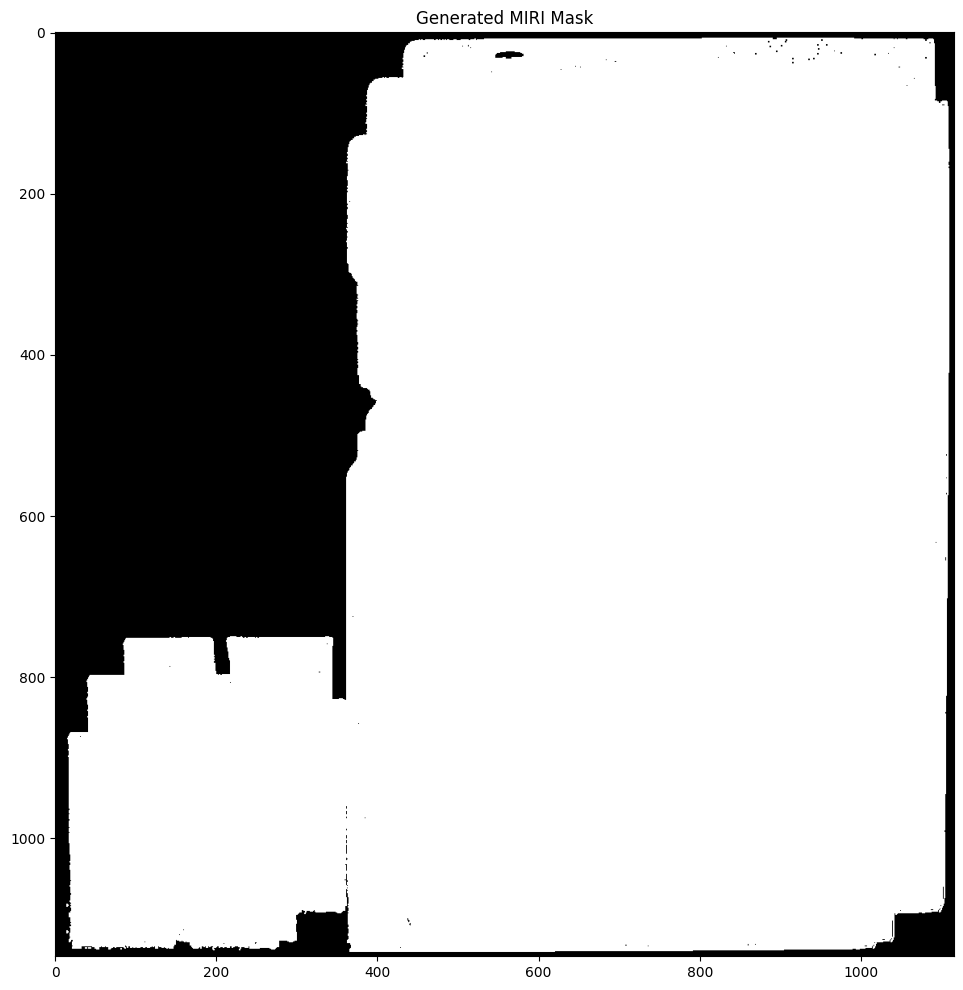

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
### mask to exclude the non-astronomical pixels
def create_miri_mask_from_all_filters():
    miri_filters = ['f770w', 'f1000w', 'f1500w', 'f1800w']
    all_images = []
    
    # Load all MIRI images with verification
    for filter_name in miri_filters:
        image_data, _ = load_images_from_local(base_dir, filter_name)
        if image_data:
            print(f"Loading original {filter_name}")
            img = image_data[0]  # Take first image
            all_images.append(img)
            print(f"Loaded {filter_name} shape: {img.shape}")
    
    # Convert to numpy array
    all_images = np.array(all_images)
    
    # Create mask based on statistical properties
    mean_image = np.mean(all_images, axis=0)
    std_image = np.std(all_images, axis=0)
    
    # Create mask where variation is within expected range
    mask = (mean_image > np.median(mean_image) * 0.5)  # Adjust threshold as needed
    
    # Display the mask for verification
    plt.figure(figsize=(12,12))
    plt.imshow(mask, cmap='gray')
    plt.title('Generated MIRI Mask')
    plt.show()
    
    return mask

create_miri_mask_from_all_filters()

Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f770w_i2d.fits
Loading original f770w
Loaded f770w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1000w_i2d.fits
Loading original f1000w
Loaded f1000w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1500w_i2d.fits
Loading original f1500w
Loaded f1500w shape: (1147, 1116)
Loading: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1800w_i2d.fits
Loading original f1800w
Loaded f1800w shape: (1147, 1116)


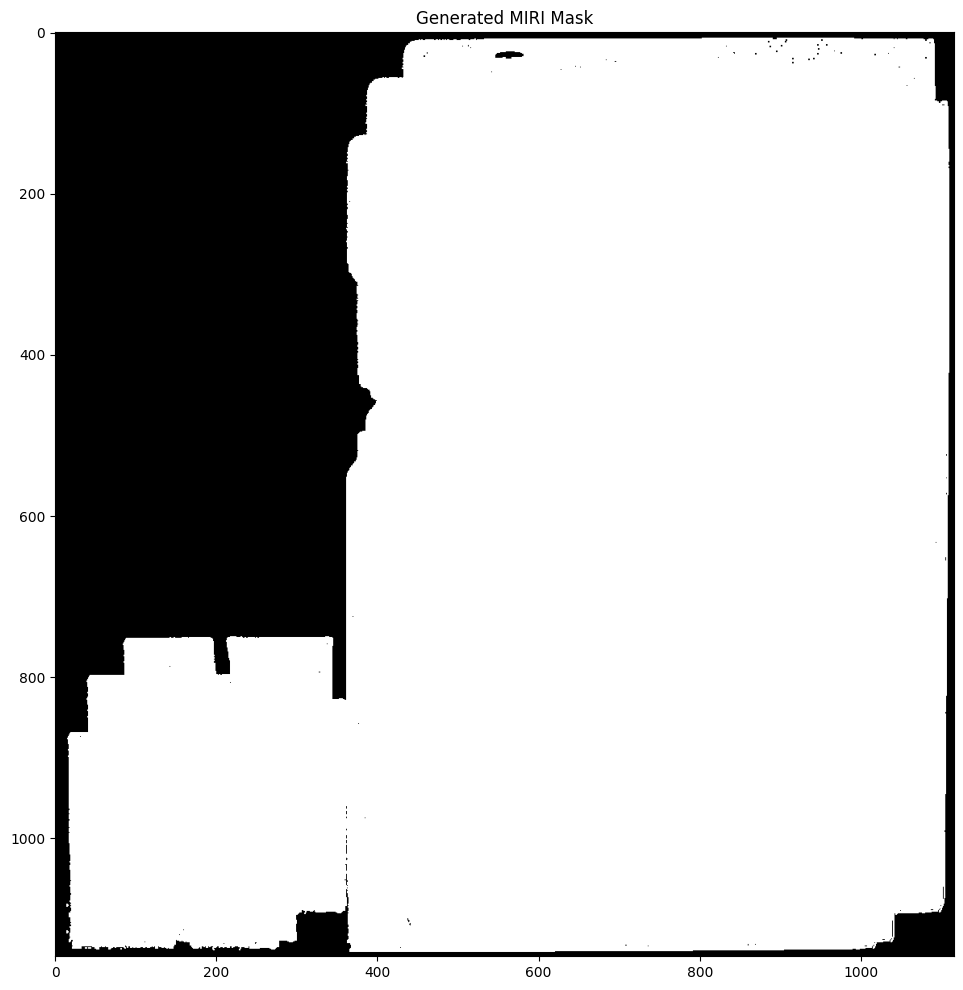

Mask saved to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\miri_mask.fits


In [12]:
### save the mask
mask = create_miri_mask_from_all_filters()
output_dir = r"C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output"
mask_path = os.path.join(output_dir, 'miri_mask.fits')
fits.writeto(mask_path, mask.astype(np.uint8), overwrite=True)
print(f"Mask saved to: {mask_path}")

In [ ]:
"""def preprocess_jwst_images(image_data, filter_name):
    # Load MIRI mask if processing MIRI filters
    if 'f770w' in filter_name.lower() or 'f1000w' in filter_name.lower() or 'f1500w' in filter_name.lower() or 'f1800w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
    
    def remove_cosmics(image):
        chunk_size = 2048
        height, width = image.shape
        cleaned_image = np.zeros_like(image)
        
        for y in range(0, height, chunk_size):
            for x in range(0, width, chunk_size):
                y_end = min(y + chunk_size, height)
                x_end = min(x + chunk_size, width)
                chunk = image[y:y_end, x:x_end]
                mask, cleaned_chunk = detect_cosmics(chunk)
                cleaned_image[y:y_end, x:x_end] = cleaned_chunk
                
        return cleaned_image
    
    def subtract_background(image):
        if 'f770w' in filter_name.lower() or 'f1000w' in filter_name.lower() or 'f1500w' in filter_name.lower() or 'f1800w' in filter_name.lower():
            image = image * mask
        bkg = Background2D(image, box_size=50)
        return image - bkg.background
    
    preprocess_dir = r"C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\0preprocess"
    os.makedirs(preprocess_dir, exist_ok=True)
    
    processed_images = []
    for idx, img in enumerate(image_data):
        cleaned = remove_cosmics(img)
        bkg_subtracted = subtract_background(cleaned)
        processed_images.append(bkg_subtracted)
        
        # Save preprocessed image
        preprocess_path = os.path.join(preprocess_dir, f'{filter_name}_preprocess_{idx}.fits')
        fits.writeto(preprocess_path, bkg_subtracted, overwrite=True)
        print(f"Saved preprocessed image: {preprocess_path}")
    
    return processed_images"""

In [ ]:
# for removal
# Background neutralization and multi-method alignment
def normalize_background(img, target_background=10.0):
    current_background = np.median(img[img > 0])
    scale_factor = target_background / current_background
    return img * scale_factor

def multi_method_alignment(images, reference, filter_name=''):
    reference = reference.astype(np.float32)
    
    # Set default FWHM based on filter
    fwhm = 3.0  # default value
    if filter_name and isinstance(filter_name, str):
        if 'f090w' in filter_name.lower():
            fwhm = 2.5
        elif 'f150w' in filter_name.lower():
            fwhm = 3.0
        else:
            fwhm = 3.5
    
    def normalize_image(img, percentiles=(2, 98)):
        p_low, p_high = np.percentile(img, percentiles)
        img_scaled = np.clip((img - p_low) / (p_high - p_low), 0, 1)
        return (img_scaled * 255).astype(np.uint8)
    
    # Apply MIRI filters-specific settings
    if 'f770w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        reference = normalize_background(reference * mask)
        percentiles = (0.1, 99.9)
        for idx, img in enumerate(images):
            images[idx] = normalize_background(img * mask)
    elif 'f1000w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        reference = normalize_background(reference * mask)
        percentiles = (0.05, 99.95)
        for idx, img in enumerate(images):
            images[idx] = normalize_background(img * mask)
    elif 'f1500w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        reference = normalize_background(reference * mask)
        percentiles = (0.1, 99.9)
        for idx, img in enumerate(images):
            images[idx] = normalize_background(img * mask)
    elif 'f1800w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        reference = normalize_background(reference * mask)
        percentiles = (0.01, 99.99)
        for idx, img in enumerate(images):
            images[idx] = normalize_background(img * mask)
    else:
        percentiles = (2, 98)  # Default for NIRCAM
    
    reference_norm = normalize_image(reference, percentiles)
    aligned_images = []
    
    for idx, img in enumerate(images):
        img = img.astype(np.float32)
        img_norm = normalize_image(img, percentiles)
        aligned_path = os.path.join(output_dir, 'aligned', f'{filter_name}_aligned_{idx}.fits')
        os.makedirs(os.path.join(output_dir, 'aligned'), exist_ok=True)
        
        try:
            aligned, _ = aa.register(img_norm, reference_norm)
            print(f"Aligned {filter_name} using astroalign")
        except Exception as e1:
            try:
                shift_result, error, _ = phase_cross_correlation(reference_norm, img_norm)
                aligned = ndimage.shift(img, shift_result)
                print(f"Aligned {filter_name} using phase correlation")
            except Exception as e2:
                print(f"Using original image for {filter_name}")
                aligned = img
        
        aligned_images.append(aligned)
        fits.writeto(aligned_path, aligned, overwrite=True)
        print(f"Saved image for {filter_name} to {aligned_path}")
                
    return aligned_images

nircam_filters = ['f090w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']
miri_filters = ['f770w', 'f1000w', 'f1500w', 'f1800w']
filters = nircam_filters + miri_filters

# Generate aligned images
for filter_name in filters:
    print(f"Processing alignment for {filter_name}")
    image_data, image_files = load_images_from_local(base_dir, filter_name)
    if image_data:
        print(f"Found {len(image_data)} images for {filter_name}")
        reference_image = image_data[0]
        aligned_images = multi_method_alignment(image_data, reference_image, filter_name)
        print(f"Alignment completed for {filter_name}")
    else:
        print(f"No images found for {filter_name}")

In [16]:
# (revised, use only the original image) 
# Stretching of single-band images of NIRCAM and MIRI
stretch_types = ['linear', 'log', 'sqrt', 'arcsinh', 'mtf']

def midtone_transfer_function(x, midtone=0.5):
    """
    Implements Siril's MTF for better contrast adjustment
    x: input array (normalized between 0 and 1)
    midtone: controls the brightness transfer
    """
    # Normalize input to 0-1 range first
    x_min = np.min(x)
    x_max = np.max(x)
    x_norm = (x - x_min) / (x_max - x_min)
    
    # Siril's MTF implementation
    return (midtone - 1) * x_norm / ((2 * midtone - 1) * x_norm - midtone)

def enhanced_auto_stretch(data):
    zscale = ZScaleInterval()
    stretch = AsinhStretch(a=0.05)
    data_zscaled = zscale(data)
    data_stretched = stretch(data_zscaled)
    return midtone_transfer_function(data_stretched, midtone=0.2)

def apply_stretch(data, stretch_type='linear'):
    interval = PercentileInterval(99.5)
    clip_factor = 1.0

    # Adjust percentile clipping as MIRI has different dynamic range
    if 'f770w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
        interval = PercentileInterval(99.9)
        clip_factor = 0.02
        mtf_midtone = 0.3
    elif 'f1000w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
        interval = PercentileInterval(99.95)
        clip_factor = 0.03
        mtf_midtone = 0.35
    elif 'f1500w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
        interval = PercentileInterval(99.9)
        clip_factor = 0.05
        mtf_midtone = 0.4
    elif 'f1800w' in filter_name.lower():
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
        interval = PercentileInterval(99.99)
        clip_factor = 0.08
        mtf_midtone = 0.45

    clipped_data = interval(data) * clip_factor
    
    if stretch_type == 'linear':
        return clipped_data
    elif stretch_type == 'log':
        return LogStretch(a=100)(clipped_data)
    elif stretch_type == 'sqrt':
        return SqrtStretch()(clipped_data)
    elif stretch_type == 'arcsinh':
        return AsinhStretch(a=0.05)(clipped_data)
    elif stretch_type == 'mtf':
        return enhanced_auto_stretch(clipped_data)

def process_single_band_image(base_dir, filter_name):
    if 'f770w' in filter_name.lower() or 'f1000w' in filter_name.lower() or 'f1500w' in filter_name.lower() or 'f1800w' in filter_name.lower():
        original_path = os.path.join(base_dir, f'jw02736-o002_t001_miri_{filter_name}_i2d.fits')
    else:
        original_path = os.path.join(base_dir, f'jw02736-o001_t001_nircam_clear-{filter_name}_i2d.fits')
    
    original_data = fits.getdata(original_path)
    
    # Get original dimensions
    orig_height, orig_width = original_data.shape
    
    # Calculate preview dimensions
    scale_factor = 100 / min(orig_width, orig_height)
    preview_height = int(orig_height * scale_factor)
    preview_width = int(orig_width * scale_factor)
    
    # Create preview version
    preview_data = resize(original_data, (preview_height, preview_width), preserve_range=True)
    
    stretched_images = {}
    stretched_images['preview_data'] = preview_data
    
    for stretch in stretch_types:
        print(f"Applying {stretch} stretch to {filter_name}")
        
        # Process full resolution
        stretched_full = np.array(apply_stretch(original_data, stretch))
        # Process preview
        stretched_preview = np.array(apply_stretch(preview_data, stretch))
        
        if stretched_full is not None and stretched_preview is not None:
            # Save full resolution stretched image
            full_res_path = os.path.join(output_dir, 'full_stretched', f'{filter_name}_{stretch}_full.fits')
            fits.writeto(full_res_path, stretched_full, overwrite=True)
            
            # Save preview stretched image
            preview_path = os.path.join(output_dir, 'preview_stretched', f'{filter_name}_{stretch}_preview.png')
            plt.imsave(preview_path, stretched_preview, cmap='gray')
            
            print(f"Saved full resolution to: {full_res_path}")
            print(f"Saved preview to: {preview_path}")
            
            stretched_images[stretch] = {'full': stretched_full, 'preview': stretched_preview}
    
    return stretched_images

nircam_filters = ['f090w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']
miri_filters = ['f770w', 'f1000w', 'f1500w', 'f1800w']
filters = nircam_filters + miri_filters

for filter_name in filters:
    process_single_band_image(base_dir, filter_name)

Applying linear stretch to f090w
Saved full resolution to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\full_stretched\f090w_linear_full.fits
Saved preview to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\preview_stretched\f090w_linear_preview.png
Applying log stretch to f090w
Saved full resolution to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\full_stretched\f090w_log_full.fits
Saved preview to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\preview_stretched\f090w_log_preview.png
Applying sqrt stretch to f090w
Saved full resolution to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\full_stretched\f090w_sqrt_full.fits
Saved preview to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\preview_stretched\f090w_sqrt_preview.png
Applying arcsinh stretch to f090w
Saved full resolution to: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\full_stretched\f090w_arcsinh_full.fits
Saved preview to: C:\Users\ronma\3D Objects\THESIS

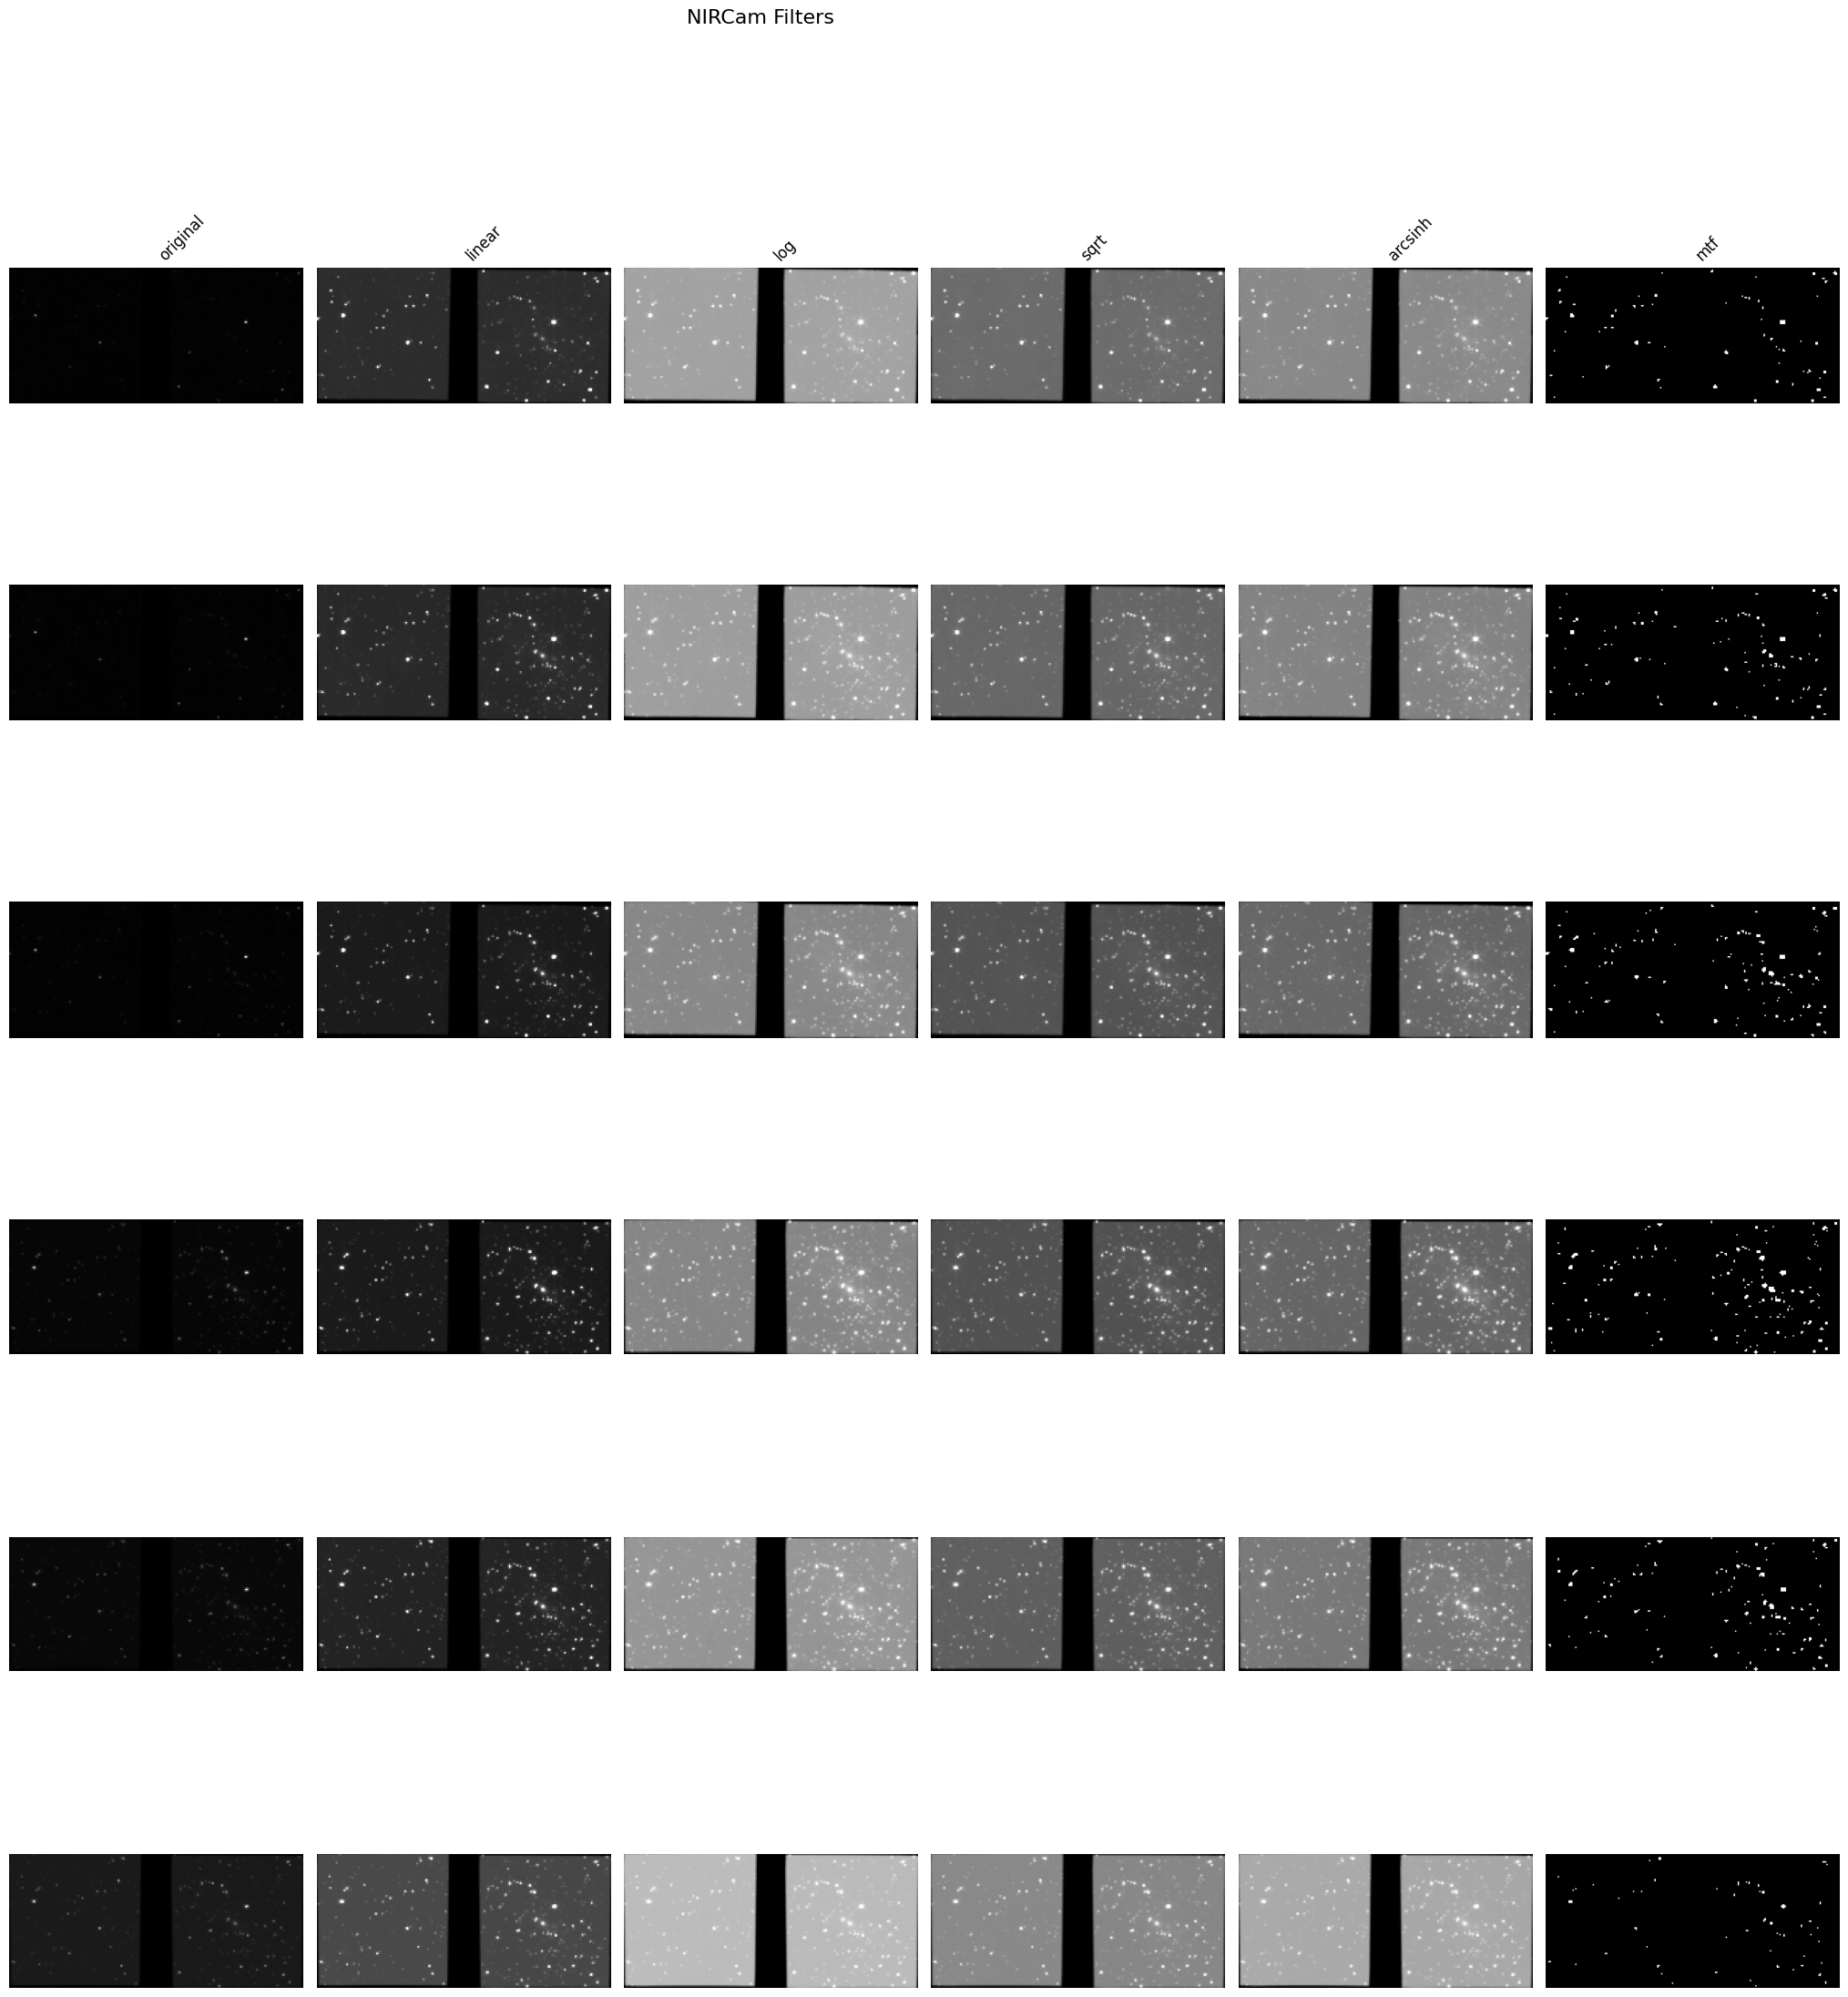

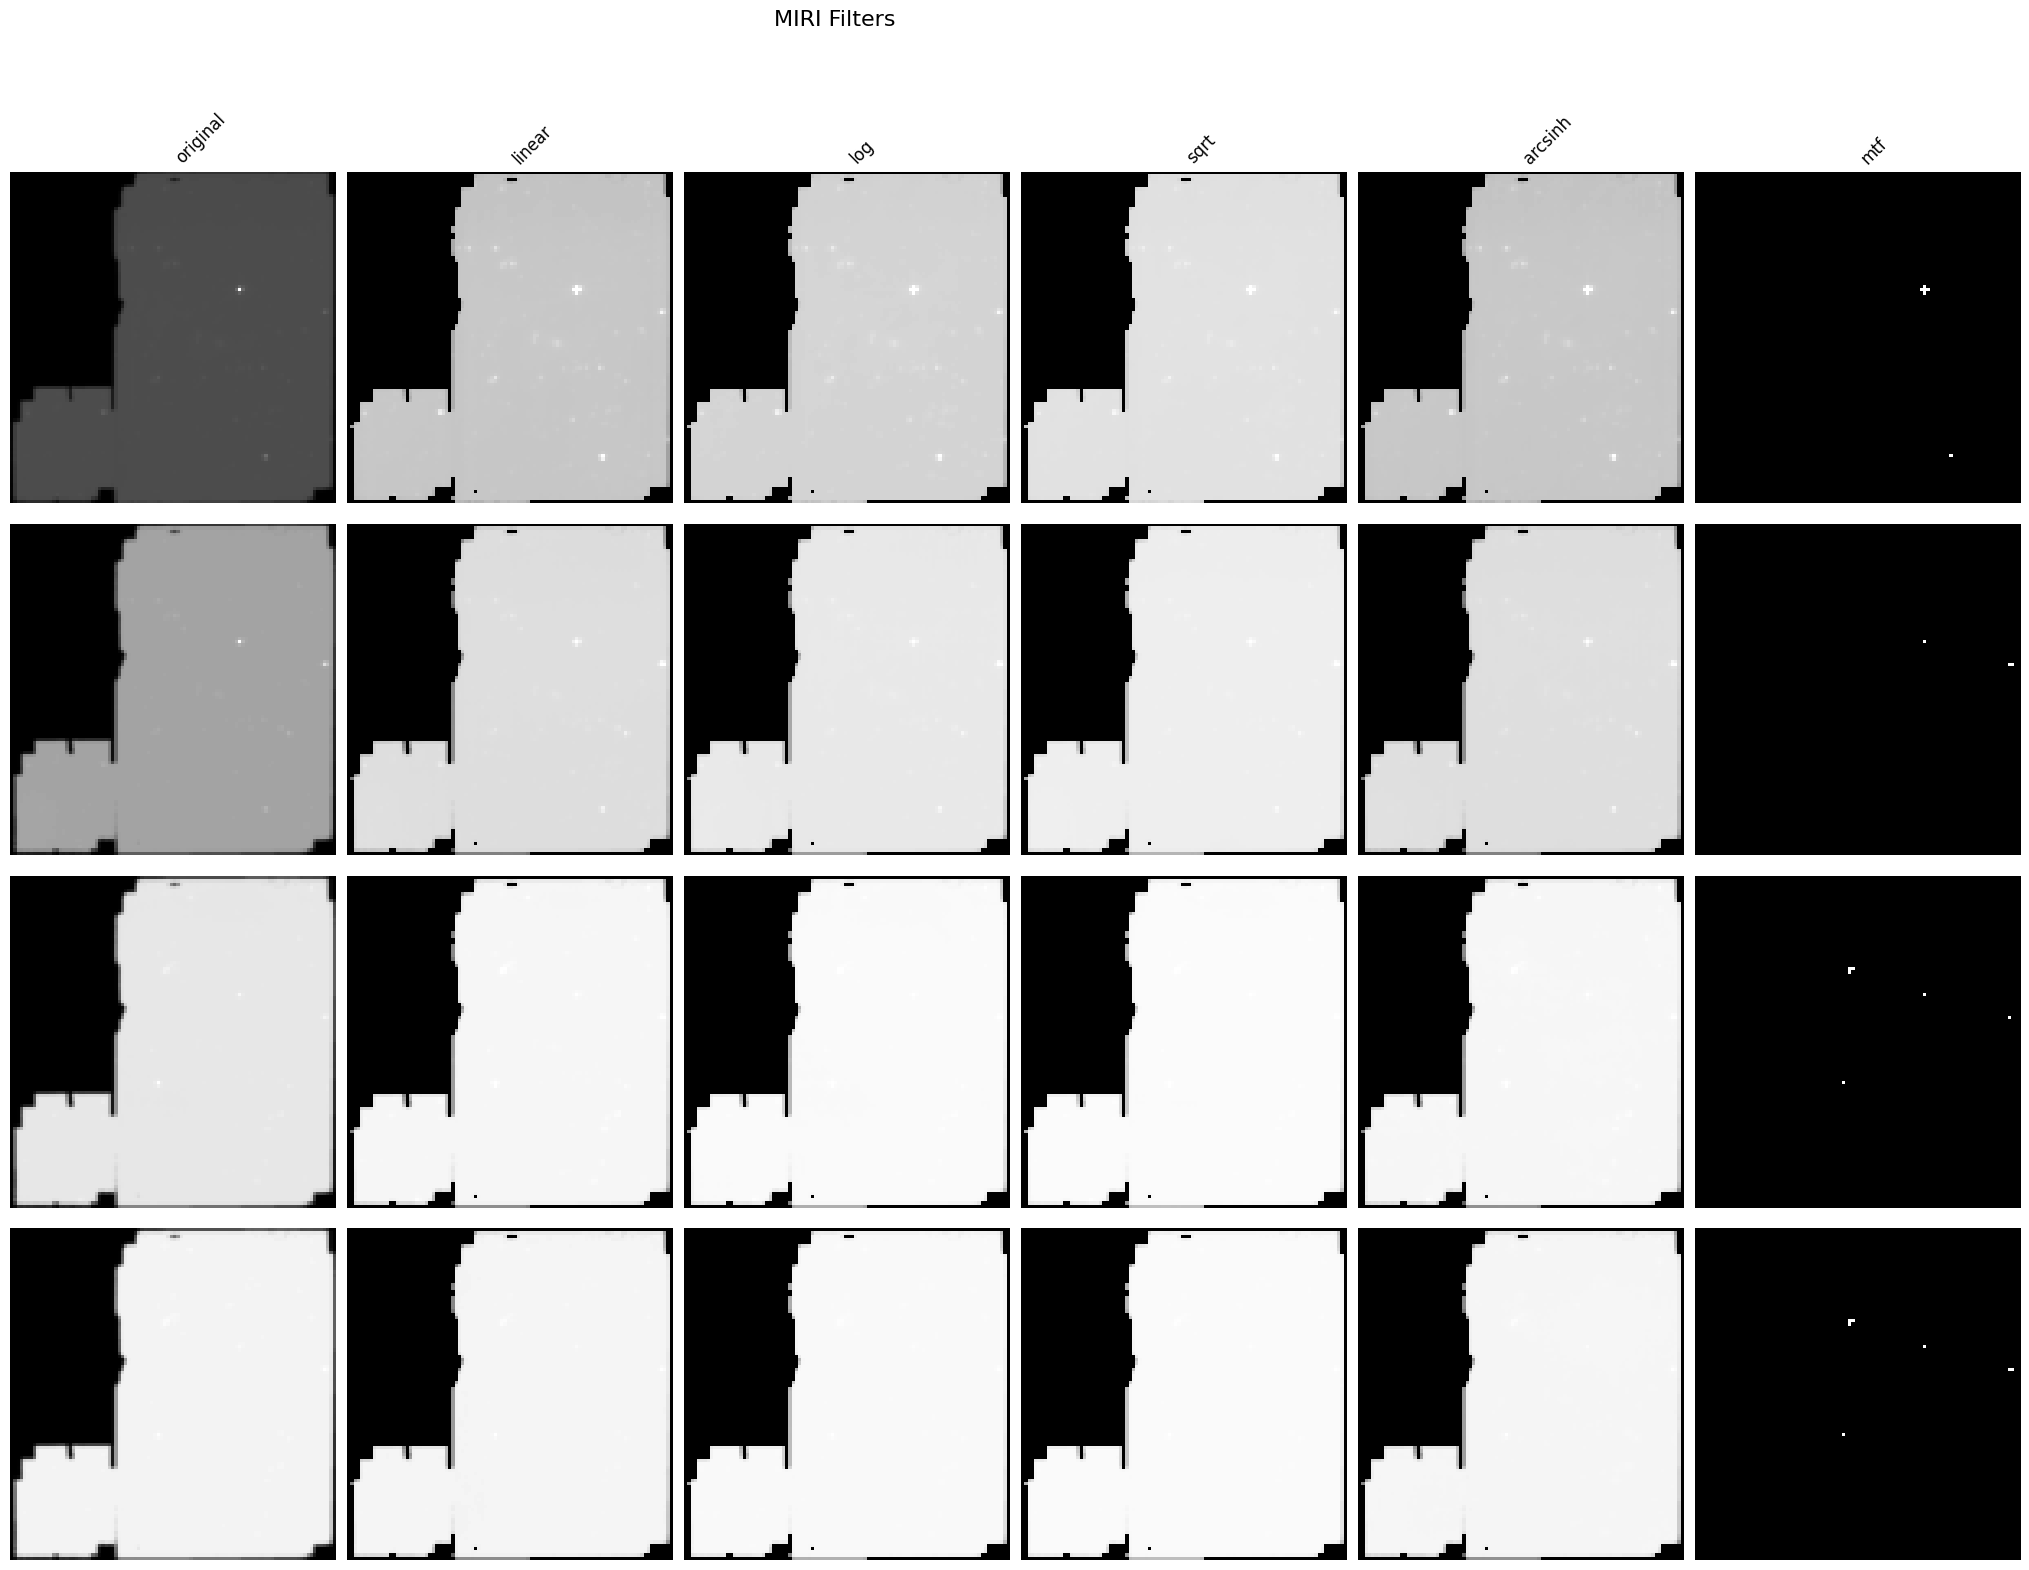

In [17]:
def create_filter_stretch_grid(output_dir, filters, stretch_types, title):
    n_filters = len(filters)
    n_stretches = len(stretch_types)
    
    fig, axes = plt.subplots(n_filters, n_stretches, figsize=(4*n_stretches, 4*n_filters))
    fig.suptitle(title, fontsize=16)
    
    # Add column headers
    for j, stretch in enumerate(stretch_types):
        axes[0, j].set_title(stretch, rotation=45, ha='left')
    
    # Add row headers and plot images
    for i, filter_name in enumerate(filters):
        axes[i, 0].set_ylabel(filter_name.upper(), rotation=0, ha='right', va='center', 
                            labelpad=40, fontsize=14, fontweight='bold')
        
        for j, stretch in enumerate(stretch_types):
            if stretch == 'original':
                # Load original data
                if 'f770w' in filter_name.lower() or 'f1000w' in filter_name.lower() or 'f1500w' in filter_name.lower() or 'f1800w' in filter_name.lower():
                    original_path = os.path.join(base_dir, f'jw02736-o002_t001_miri_{filter_name}_i2d.fits')
                else:
                    original_path = os.path.join(base_dir, f'jw02736-o001_t001_nircam_clear-{filter_name}_i2d.fits')
                
                if os.path.exists(original_path):
                    original_data = fits.getdata(original_path)
                    preview_height = int(original_data.shape[0] * 100 / min(original_data.shape))
                    preview_width = int(original_data.shape[1] * 100 / min(original_data.shape))
                    preview = resize(original_data, (preview_height, preview_width), preserve_range=True)
                    axes[i, j].imshow(preview, cmap='gray')
            else:
                preview_path = os.path.join(output_dir, 'preview_stretched', f'{filter_name}_{stretch}_preview.png')
                if os.path.exists(preview_path):
                    img = plt.imread(preview_path)
                    axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout(rect=[0.15, 0, 1, 0.95])
    plt.show()

stretch_types = ['original', 'linear', 'log', 'sqrt', 'arcsinh', 'mtf']

# Create visualization grids
create_filter_stretch_grid(output_dir, nircam_filters, stretch_types, 'NIRCam Filters')
create_filter_stretch_grid(output_dir, miri_filters, stretch_types, 'MIRI Filters')

Loading mask from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\miri_mask.fits
Loading image from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f770w_i2d.fits
Mask shape: (1147, 1116)
Image shape: (1147, 1116)


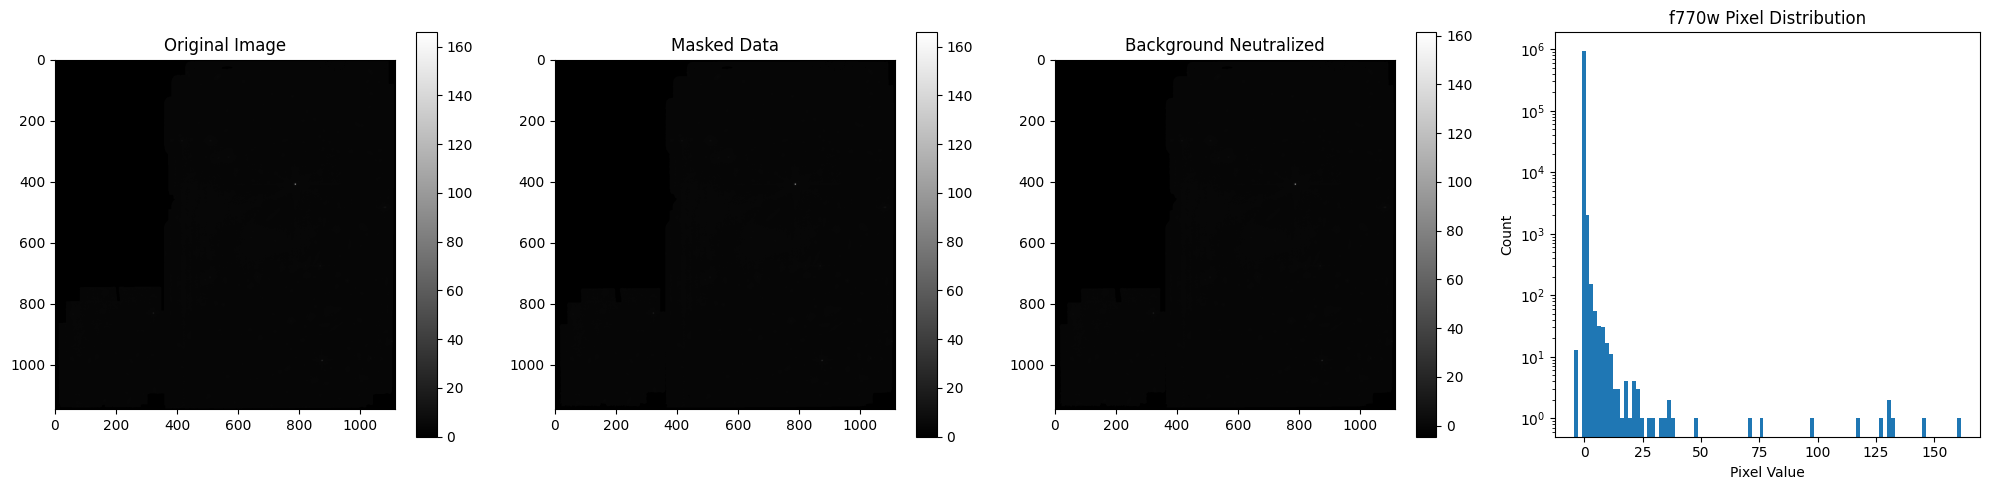


Analyzing astronomical f770w data:
Background level: 4.511664867401123
Min value: -4.511664867401123
Max value: 161.32574462890625
Mean value: 0.0020740993786603212
Std dev: 0.4331335425376892


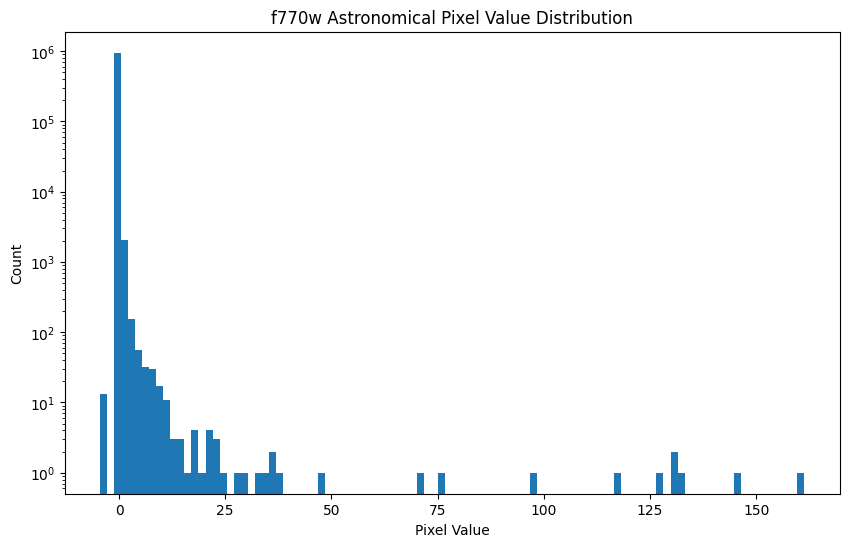

Loading mask from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\miri_mask.fits
Loading image from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1000w_i2d.fits
Mask shape: (1147, 1116)
Image shape: (1147, 1116)


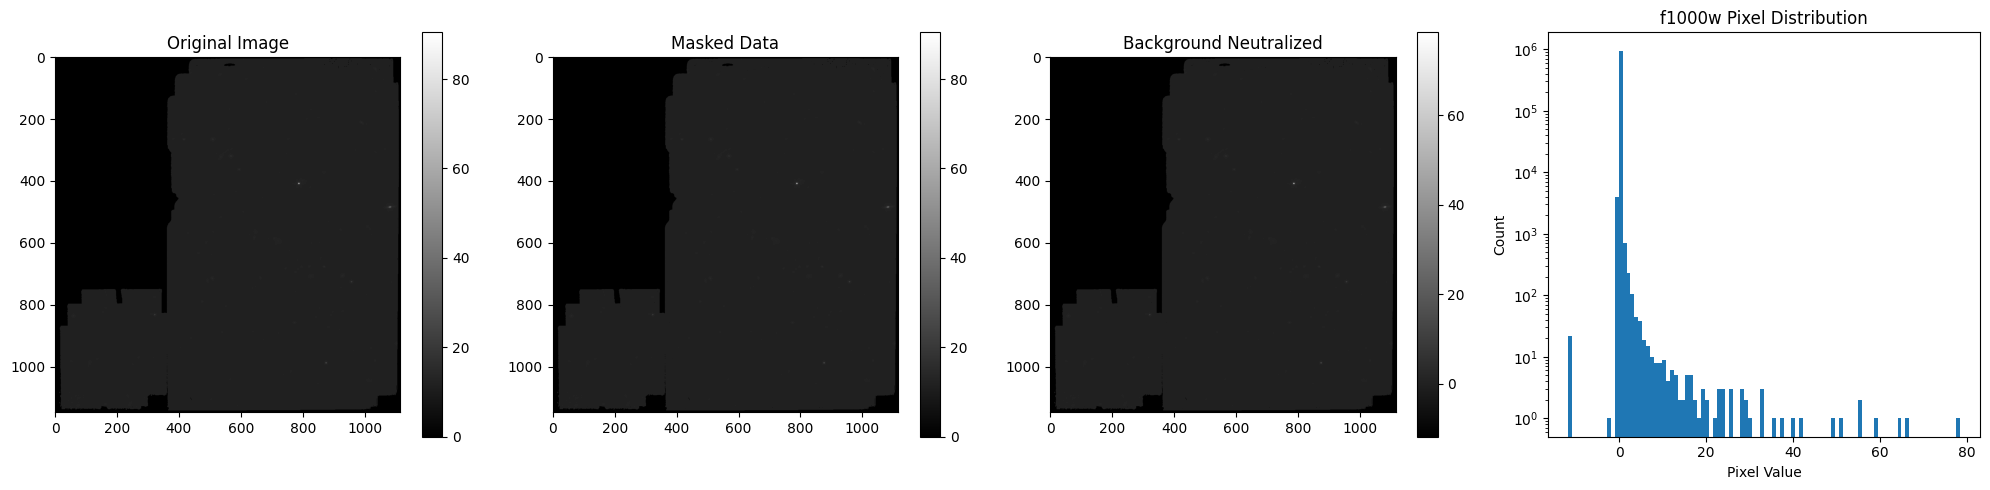


Analyzing astronomical f1000w data:
Background level: 11.878260612487793
Min value: -11.878260612487793
Max value: 78.57575225830078
Mean value: 0.006205480080097914
Std dev: 0.2751239240169525


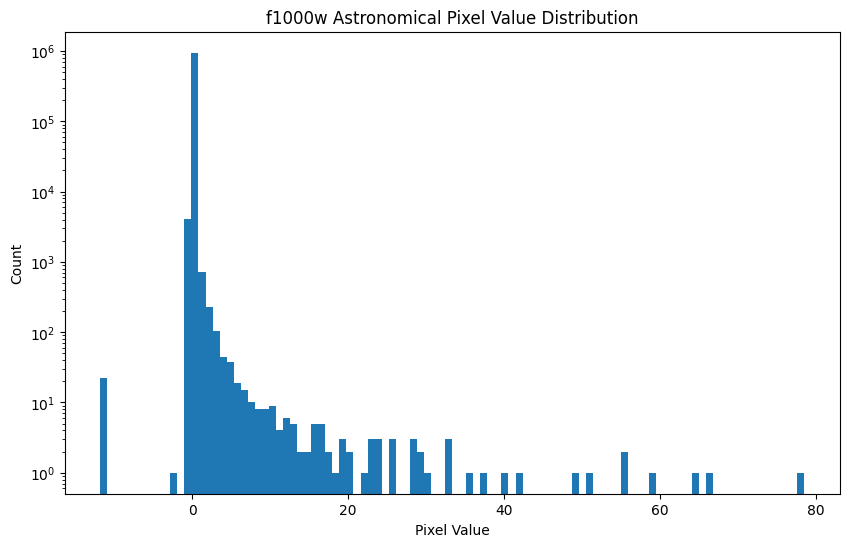

Loading mask from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\miri_mask.fits
Loading image from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1500w_i2d.fits
Mask shape: (1147, 1116)
Image shape: (1147, 1116)


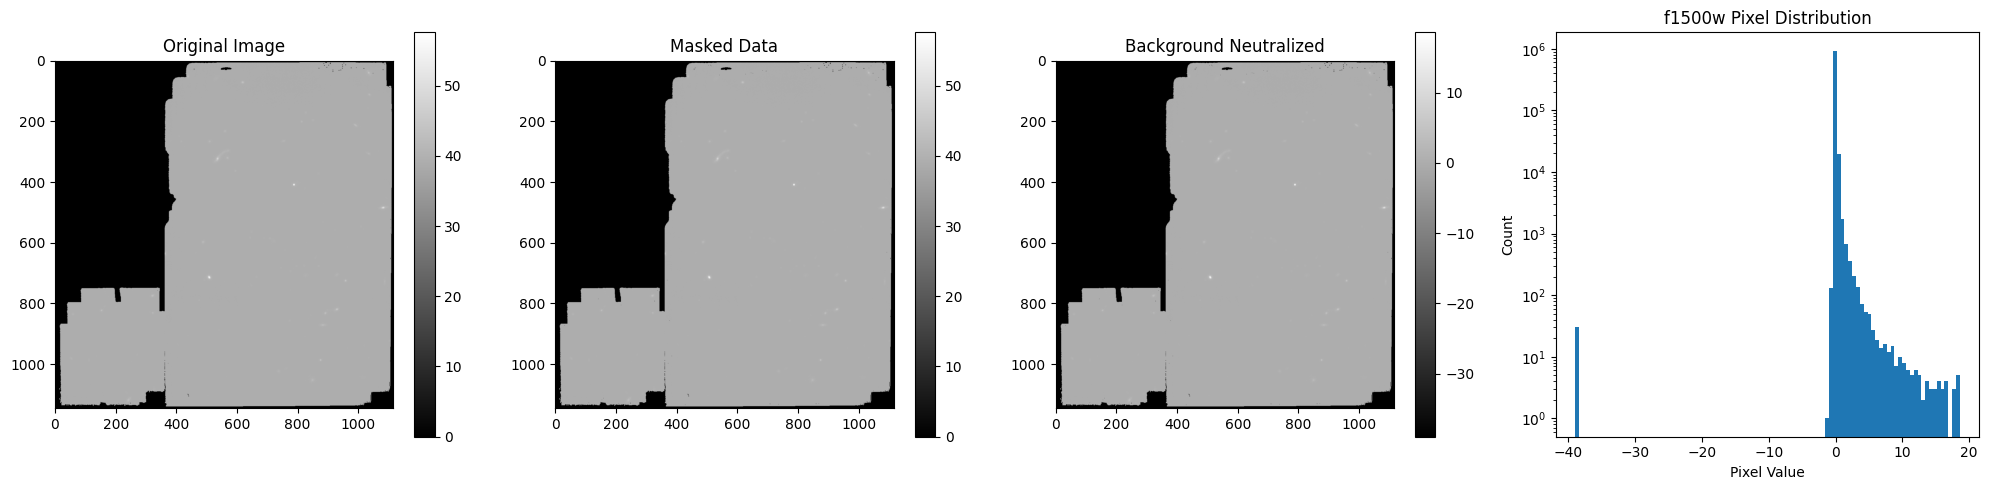


Analyzing astronomical f1500w data:
Background level: 38.98273849487305
Min value: -38.98273849487305
Max value: 18.59449005126953
Mean value: 0.008573977276682854
Std dev: 0.2908591628074646


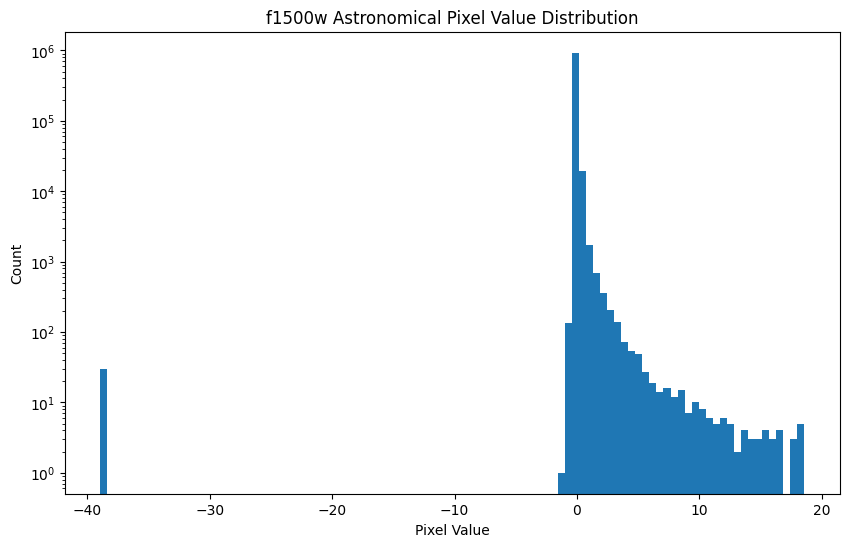

Loading mask from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\output\miri_mask.fits
Loading image from: C:\Users\ronma\3D Objects\THESIS300A\jwst_images\jw02736-o002_t001_miri_f1800w_i2d.fits
Mask shape: (1147, 1116)
Image shape: (1147, 1116)


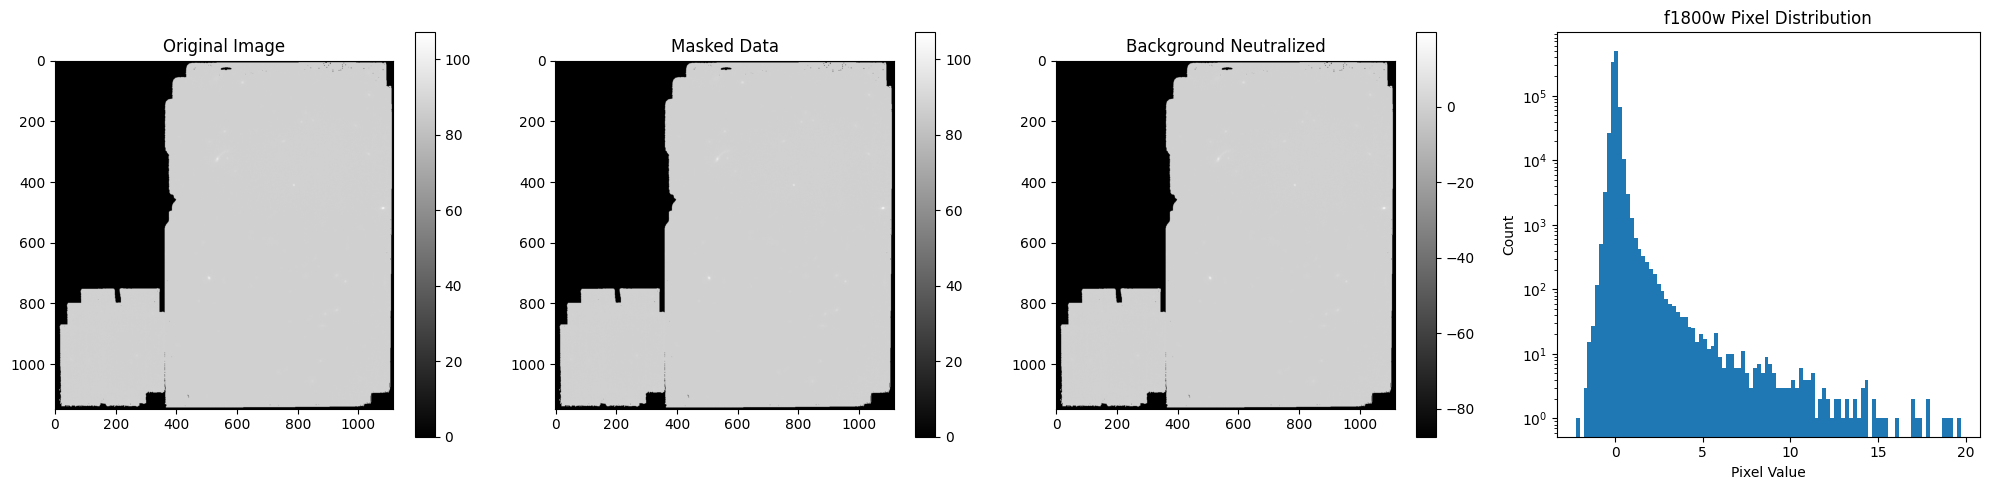


Analyzing astronomical f1800w data:
Background level: 87.42689514160156
Min value: -2.2295913696289062
Max value: 19.721649169921875
Mean value: 0.012922437861561775
Std dev: 0.24060668051242828


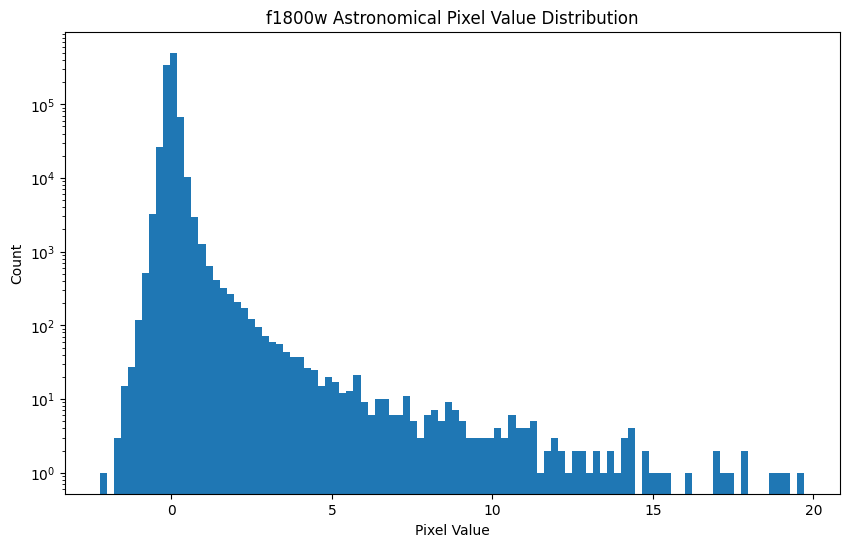

In [23]:
def analyze_astronomical_miri_data(filter_name):
    # Load original image
    filepath = os.path.join(base_dir, f'jw02736-o002_t001_miri_{filter_name}_i2d.fits')
    mask_path = os.path.join(output_dir, 'miri_mask.fits')
    
    print(f"Loading mask from: {mask_path}")
    print(f"Loading image from: {filepath}")
    
    if os.path.exists(filepath) and os.path.exists(mask_path):
        original_data = fits.getdata(filepath)
        mask = fits.getdata(mask_path).astype(bool)
        
        # Show mask dimensions and data
        print(f"Mask shape: {mask.shape}")
        print(f"Image shape: {original_data.shape}")
        
        # Load and apply mask first
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, original_data.shape, preserve_range=True).astype(bool)
        masked_data = original_data * mask_resized
        
        # Background neutralization on masked data
        background = np.median(masked_data[masked_data > 0])
        astronomical_data = masked_data - background
        
        # Visualization
        plt.figure(figsize=(20,5))
        plt.subplot(141)
        plt.imshow(original_data, cmap='gray')
        plt.title('Original Image')
        plt.colorbar()
        
        plt.subplot(142)
        plt.imshow(masked_data, cmap='gray')
        plt.title('Masked Data')
        plt.colorbar()
        
        plt.subplot(143)
        plt.imshow(astronomical_data, cmap='gray')
        plt.title('Background Neutralized')
        plt.colorbar()
        
        plt.subplot(144)
        plt.hist(astronomical_data[mask_resized].flatten(), bins=100)
        plt.title(f'{filter_name} Pixel Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Count')
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print(f"\nAnalyzing astronomical {filter_name} data:")
        print(f"Background level: {background}")
        print(f"Min value: {np.min(astronomical_data[mask_resized])}")
        print(f"Max value: {np.max(astronomical_data[mask_resized])}")
        print(f"Mean value: {np.mean(astronomical_data[mask_resized])}")
        print(f"Std dev: {np.std(astronomical_data[mask_resized])}")
        
        plt.figure(figsize=(10,6))
        plt.hist(astronomical_data[mask_resized].flatten(), bins=100)
        plt.title(f'{filter_name} Astronomical Pixel Value Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Count')
        plt.yscale('log')
        plt.show()



# Process each MIRI filter
miri_filters = ['f770w', 'f1000w', 'f1500w', 'f1800w']
for filter_name in miri_filters:
    analyze_astronomical_miri_data(filter_name)

Testing NIRCAM F090W


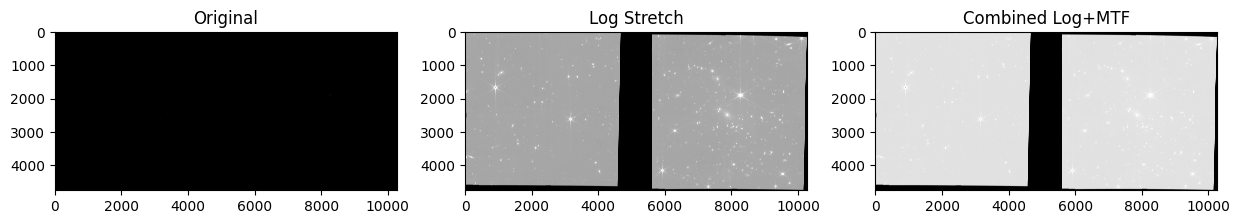

Testing MIRI F1500W


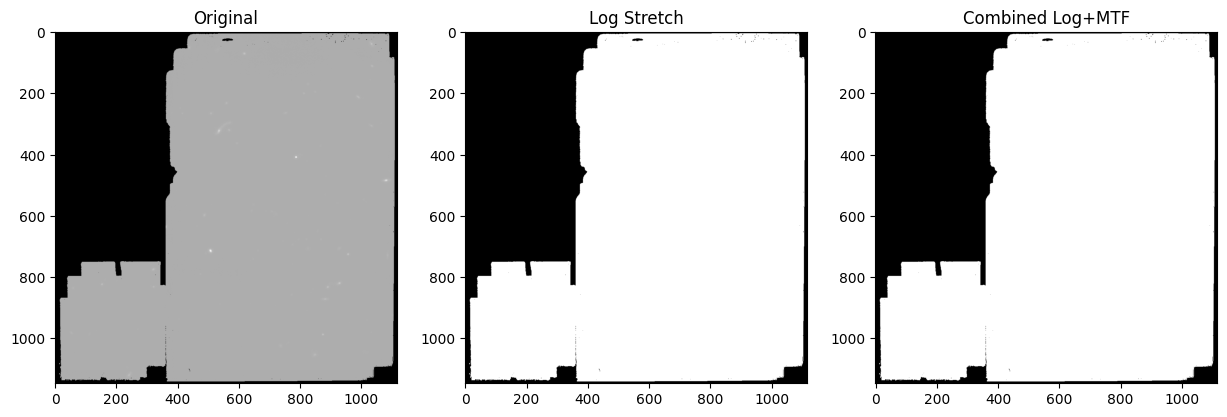

In [31]:
def test_combined_mtf_log(image_path, is_miri=False):
    # Load image
    data = fits.getdata(image_path)
    
    # Apply mask if MIRI
    if is_miri:
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
    
    # Apply log stretch first
    log_stretched = LogStretch(a=100)(data)
    
    # Then apply MTF
    final_stretch = midtone_transfer_function(log_stretched, midtone=0.2)
    
    # Visualize results
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(data, cmap='gray')
    plt.title('Original')
    
    plt.subplot(132)
    plt.imshow(log_stretched, cmap='gray')
    plt.title('Log Stretch')
    
    plt.subplot(133)
    plt.imshow(final_stretch, cmap='gray')
    plt.title('Combined Log+MTF')
    
    plt.show()

# Test with NIRCAM F090W
nircam_path = os.path.join(base_dir, 'jw02736-o001_t001_nircam_clear-f090w_i2d.fits')
print("Testing NIRCAM F090W")
test_combined_mtf_log(nircam_path, is_miri=False)

# Test with MIRI F1500W
miri_path = os.path.join(base_dir, 'jw02736-o002_t001_miri_f1500w_i2d.fits')
print("Testing MIRI F1500W")
test_combined_mtf_log(miri_path, is_miri=True)

Testing NIRCAM F090W


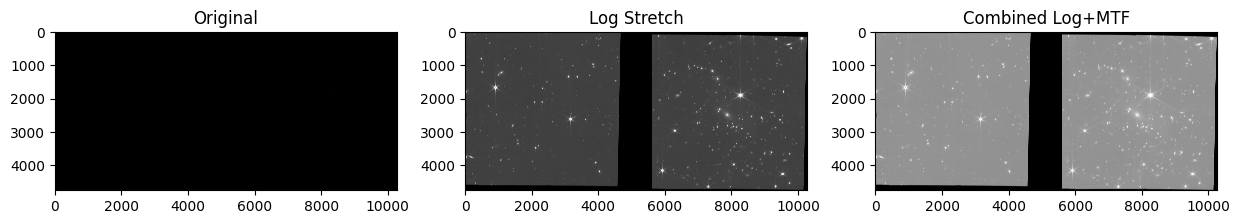

Testing MIRI F1500W


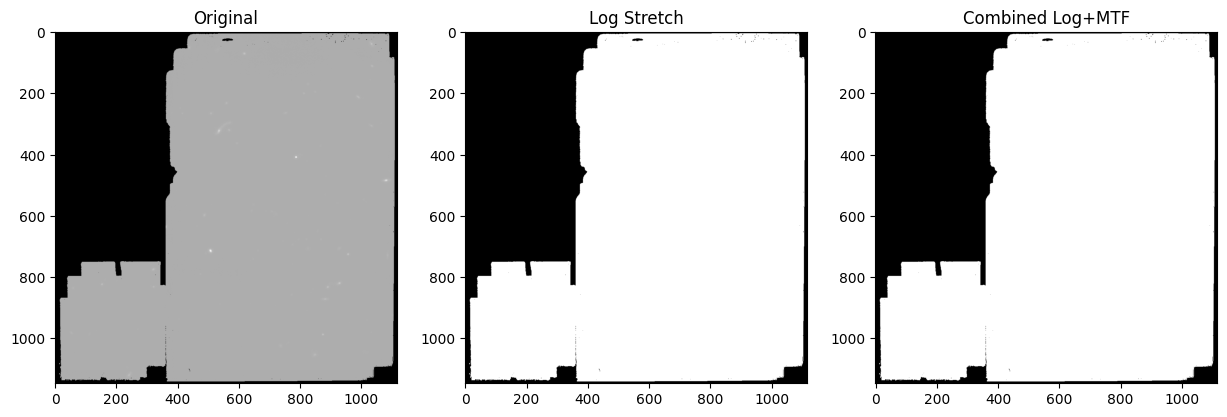

In [30]:
def midtone_transfer_function(x, midtone=0.05):
    """
    Implements Siril's MTF for better contrast adjustment
    x: input array (normalized between 0 and 1)
    midtone: controls the brightness transfer
    """
    x_min = np.min(x)
    x_max = np.max(x)
    x_norm = (x - x_min) / (x_max - x_min)
    return (midtone - 1) * x_norm / ((2 * midtone - 1) * x_norm - midtone)

def test_combined_mtf_log(image_path, is_miri=False):
    # Load image
    data = fits.getdata(image_path)
    
    # Apply mask if MIRI
    if is_miri:
        mask = fits.getdata(os.path.join(output_dir, 'miri_mask.fits')).astype(bool)
        mask_resized = resize(mask, data.shape, preserve_range=True).astype(bool)
        data = data * mask_resized
    
    # Apply log stretch first
    log_stretched = LogStretch(a=1)(data)
    
    # Then apply MTF
    final_stretch = midtone_transfer_function(log_stretched, midtone=0.2)
    
    # Visualize results
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(data, cmap='gray')
    plt.title('Original')
    
    plt.subplot(132)
    plt.imshow(log_stretched, cmap='gray')
    plt.title('Log Stretch')
    
    plt.subplot(133)
    plt.imshow(final_stretch, cmap='gray')
    plt.title('Combined Log+MTF')
    
    plt.show()

# Test with NIRCAM F090W
nircam_path = os.path.join(base_dir, 'jw02736-o001_t001_nircam_clear-f090w_i2d.fits')
print("Testing NIRCAM F090W")
test_combined_mtf_log(nircam_path, is_miri=False)

# Test with MIRI F1500W
miri_path = os.path.join(base_dir, 'jw02736-o002_t001_miri_f1500w_i2d.fits')
print("Testing MIRI F1500W")
test_combined_mtf_log(miri_path, is_miri=True)

In [ ]:

"""
def create_rgb_composite(blue_data, green_data, red_data, instrument_name, combination_name='', stretch_type=''):
    if not (blue_data and green_data and red_data):
        print(f"Missing data for {instrument_name} RGB composite")
        return

    # Get original dimensions
    orig_height, orig_width = blue_data[0].shape
    print(f"Original {instrument_name} dimensions: {orig_width} x {orig_height}")

    def sigma_clipped_combine(images, sigma=3.0, maxiters=5):
        """Scientific stacking using sigma-clipped mean"""
        stacked_image, _, _ = sigma_clipped_stats(np.stack(images), sigma=sigma, maxiters=maxiters, axis=0)
        return stacked_image

    # Stack full-resolution images first
    print("Stacking channels...")
    blue_stack = sigma_clipped_combine(blue_data)
    green_stack = sigma_clipped_combine(green_data)
    red_stack = sigma_clipped_combine(red_data)

    # Save full resolution stacked images
    full_res_path = os.path.join(output_dir, f'{instrument_name.lower()}_fullres_{combination_name}')
    np.save(f"{full_res_path}_blue.npy", blue_stack)
    np.save(f"{full_res_path}_green.npy", green_stack)
    np.save(f"{full_res_path}_red.npy", red_stack)

    # Create display version
    scale_factor = 400 / min(orig_height, orig_width)
    new_height = int(orig_height * scale_factor)
    new_width = int(orig_width * scale_factor)
    target_size = (new_height, new_width)

    # Resize stacked images for display
    display_blue = resize(blue_stack, target_size, preserve_range=True, mode='constant')
    display_green = resize(green_stack, target_size, preserve_range=True, mode='constant')
    display_red = resize(red_stack, target_size, preserve_range=True, mode='constant')

    # Create different RGB arrangements with descriptive names
    arrangements = [
        (display_red, display_green, display_blue, "Standard RGB"),    
        (display_blue, display_red, display_green, "BRG"),    
        (display_green, display_blue, display_red, "GBR")     
    ]

    stretch_types = ['linear', 'log', 'squared', 'arcsinh']
    
    for stretch_type in stretch_types:
        print(f"\nApplying {stretch_type} stretch to {instrument_name} images")
        
        for arrangement in arrangements:
            print(f"\nProcessing arrangement: {arrangement[3]}")
            print(f"Filter Combination: {combination_name}")
            
            # Normalize and stretch each channel
            rgb_normalized = []
            for channel in arrangement[:-1]:
                p1, p99 = np.percentile(channel, (1, 99))
                normalized = np.clip((channel - p1) / (p99 - p1), 0, 1)
                stretched = apply_stretch(normalized, stretch_type)
                rgb_normalized.append(stretched)
            
            # Create RGB composite
            rgb_image = np.dstack(rgb_normalized)
            
            # Display with proper figsize
            aspect_ratio = target_size[1] / target_size[0]
            plt.figure(figsize=(6 * aspect_ratio, 6))
            plt.imshow(rgb_image)
            plt.title(f'{instrument_name} {arrangement[3]}\n{combination_name}\n{stretch_type} stretch')
            plt.axis('on')
            plt.colorbar()
            plt.show()
            
            # Save each version
            save_path = os.path.join(output_dir, 
                                   f'{instrument_name.lower()}_{arrangement[3]}_{stretch_type}_{combination_name}.png')
            plt.imsave(save_path, rgb_image)
            print(f"Saved as: {os.path.basename(save_path)}")
            print("-" * 50)

    return blue_stack, green_stack, red_stack, rgb_image
"""

In [ ]:
"""# RGB composite with varying rgb filter, bg neutralization, and image stretching

# Image stretching
def apply_stretch(data, stretch_type='linear'):
    if stretch_type == 'linear':
        return data
    elif stretch_type == 'log':
        return np.log1p(data)
    elif stretch_type == 'squared':
        return np.square(data)
    elif stretch_type == 'arcsinh':
        return np.arcsinh(data)

# Background neutralization
def neutralize_background(image, sample_fraction=0.1):
    from astropy.stats import sigma_clipped_stats
    
    # Split channels
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    
    # Calculate background levels - unpack all three values
    r_bg, _, _ = sigma_clipped_stats(r, sigma=3)
    g_bg, _, _ = sigma_clipped_stats(g, sigma=3)
    b_bg, _, _ = sigma_clipped_stats(b, sigma=3)
    
    # Rest of the function remains the same
    target_bg = np.mean([r_bg, g_bg, b_bg])
    r_scale = target_bg / r_bg
    g_scale = target_bg / g_bg
    b_scale = target_bg / b_bg
    
    balanced = np.dstack([
        r * r_scale,
        g * g_scale,
        b * b_scale
    ])
    
    return balanced

def create_rgb_composite(blue_data, green_data, red_data, instrument_name, combination_name='', stretch_type=''):
    if not (blue_data and green_data and red_data):
        print(f"Missing data for {instrument_name} RGB composite")
        return

    # Get original dimensions
    orig_height, orig_width = blue_data[0].shape
    print(f"Original {instrument_name} dimensions: {orig_width} x {orig_height}")

    def sigma_clipped_combine(images, sigma=3.0, maxiters=5):
        """Scientific stacking using sigma-clipped mean"""
        stacked_image, _, _ = sigma_clipped_stats(np.stack(images), sigma=sigma, maxiters=maxiters, axis=0)
        return stacked_image

    # Stack full-resolution images first
    print("Stacking channels...")
    blue_stack = sigma_clipped_combine(blue_data)
    green_stack = sigma_clipped_combine(green_data)
    red_stack = sigma_clipped_combine(red_data)

    # Create display version
    scale_factor = 400 / min(orig_height, orig_width)
    new_height = int(orig_height * scale_factor)
    new_width = int(orig_width * scale_factor)
    target_size = (new_height, new_width)

    # Resize stacked images for display
    display_blue = resize(blue_stack, target_size, preserve_range=True, mode='constant')
    display_green = resize(green_stack, target_size, preserve_range=True, mode='constant')
    display_red = resize(red_stack, target_size, preserve_range=True, mode='constant')
    
    # Create different RGB arrangements with descriptive names
    arrangements = [
        (display_red, display_green, display_blue, "Standard RGB"),    
        (display_blue, display_red, display_green, "BRG"),    
        (display_green, display_blue, display_red, "GBR")     
    ]
    
    stretch_types = ['linear', 'log', 'squared', 'arcsinh']
    
    for stretch_type in stretch_types:
        print(f"\nApplying {stretch_type} stretch to {instrument_name} images")
        
        for arrangement in arrangements:
            print(f"\nProcessing arrangement: {arrangement[3]}")
            print(f"Filter Combination: {combination_name}")
            
            # Normalize and stretch each channel
            rgb_normalized = []
            for channel in arrangement[:-1]:
                p1, p99 = np.percentile(channel, (1, 99))
                normalized = np.clip((channel - p1) / (p99 - p1), 0, 1)
                stretched = apply_stretch(normalized, stretch_type)
                rgb_normalized.append(stretched)
            
            # Create RGB composite
            rgb_image = np.dstack(rgb_normalized)
            
            # Apply background neutralization
            rgb_image = neutralize_background(rgb_image)
            
            # Display with proper figsize
            aspect_ratio = target_size[1] / target_size[0]
            plt.figure(figsize=(6 * aspect_ratio, 6))
            plt.imshow(rgb_image)
            plt.title(f'{instrument_name} {arrangement[3]}\n{combination_name}\n{stretch_type} stretch')
            plt.axis('on')
            plt.colorbar()
            plt.show()
            
            # Save each version
            save_path = os.path.join(output_dir, 
                                   f'{instrument_name.lower()}_{arrangement[3]}_{stretch_type}_{combination_name}.png')
            rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
            plt.imsave(save_path, rgb_image_normalized)
            print(f"Saved as: {os.path.basename(save_path)}")
            print("-" * 50)
    
    return blue_stack, green_stack, red_stack, rgb_image"""

In [ ]:
"""# Generate a list of filter combination
def generate_filter_combinations():
    # NIRCam filters grouped by wavelength
    nircam_blue = ['f090w', 'f150w']      # Short wavelength
    nircam_green = ['f200w', 'f277w']     # Medium wavelength
    nircam_red = ['f356w', 'f444w']       # Long wavelength

    # Create combinations using wavelength-appropriate assignments
    nircam_combinations = []
    for blue in nircam_blue:
        for green in nircam_green:
            for red in nircam_red:
                nircam_combinations.append((blue, green, red))

    # MIRI filters grouped by wavelength
    miri_blue = ['f770w']
    miri_green = ['f1000w']
    miri_red = ['f1500w', 'f1800w']

    # Create MIRI combinations
    miri_combinations = []
    for blue in miri_blue:
        for green in miri_green:
            for red in miri_red:
                miri_combinations.append((blue, green, red))

    return nircam_combinations, miri_combinations

# Generate wavelength-appropriate combinations
nircam_combinations, miri_combinations = generate_filter_combinations()

print("NIRCam combinations:", len(nircam_combinations))
for combo in nircam_combinations:
    print(f"Blue: {combo[0]}, Green: {combo[1]}, Red: {combo[2]}")

print("\nMIRI combinations:", len(miri_combinations))
for combo in miri_combinations:
    print(f"Blue: {combo[0]}, Green: {combo[1]}, Red: {combo[2]}")

# Generate wavelength-appropriate combinations
nircam_combinations, miri_combinations = generate_filter_combinations()
"""

In [ ]:
"""# Generate a list of filter combination (with filter groups)
def generate_filter_combinations():
    # NIRCam optimal filter groups
    nircam_long = [
        'f277w',    # 2.77 microns
        'f444w',    # 4.44 microns
        'f356w'     # 3.56 microns
    ]
    
    nircam_short = [
        'f200w',    # 2.00 microns
        'f150w',    # 1.50 microns
        'f090w'     # 0.90 microns
    ]
    
    nircam_combinations = [
        (nircam_short[2], nircam_short[1], nircam_short[0]),  # 0.90, 1.50, 2.00 microns
        (nircam_long[0], nircam_long[2], nircam_long[1])      # 2.77, 3.56, 4.44 microns
    ]
    
    # MIRI combinations
    miri_combinations = [
        ('f770w', 'f1000w', 'f1500w'),    # 7.7, 10.0, 15.0 microns
        ('f770w', 'f1000w', 'f1800w')     # 7.7, 10.0, 18.0 microns
    ]
    
    return nircam_combinations, miri_combinations

# Generate wavelength-appropriate combinations
nircam_combinations, miri_combinations = generate_filter_combinations()

print("NIRCam combinations:", len(nircam_combinations))
for combo in nircam_combinations:
    print(f"Blue: {combo[0]}, Green: {combo[1]}, Red: {combo[2]}")

print("\nMIRI combinations:", len(miri_combinations))
for combo in miri_combinations:
    print(f"Blue: {combo[0]}, Green: {combo[1]}, Red: {combo[2]}")

# Generate wavelength-appropriate combinations
nircam_combinations, miri_combinations = generate_filter_combinations()"""

In [ ]:
"""# Generate a list of filter combination (with diff RGB arrangement and stretching)

def generate_filter_combinations():
    # NIRCam optimal filter groups
    nircam_long = [
        'f444w',    # 4.44 microns (longest)
        'f356w',    # 3.56 microns
        'f277w'     # 2.77 microns (shortest)
    ]
    
    nircam_short = [
        'f200w',    # 2.00 microns (longest)
        'f150w',    # 1.50 microns
        'f090w'     # 0.90 microns (shortest)
    ]
    
    nircam_combinations = [
        (nircam_short[2], nircam_short[1], nircam_short[0]),  # 0.90, 1.50, 2.00 microns
        (nircam_long[2], nircam_long[1], nircam_long[0])      # 2.77, 3.56, 4.44 microns
    ]
    
    # MIRI combinations (already in correct wavelength order)
    miri_combinations = [
        ('f770w', 'f1000w', 'f1500w'),    # 7.7, 10.0, 15.0 microns
        ('f770w', 'f1000w', 'f1800w')     # 7.7, 10.0, 18.0 microns
    ]
    
    return nircam_combinations, miri_combinations

# Generate wavelength-appropriate combinations
nircam_combinations, miri_combinations = generate_filter_combinations()

print("NIRCam combinations:")
for combo in nircam_combinations:
    print(f"\nFilter Group: {combo[0]}, {combo[1]}, {combo[2]}")
    print("RGB Arrangements:")
    print(f"1. Standard RGB: {combo[0]}-{combo[1]}-{combo[2]}")
    print(f"2. BRG: {combo[2]}-{combo[0]}-{combo[1]}")
    print(f"3. GBR: {combo[1]}-{combo[2]}-{combo[0]}")
    print("Each arrangement will be processed with stretches:")
    print("- linear")
    print("- log")
    print("- squared")
    print("- arcsinh")
    print("-" * 50)

print("\nMIRI combinations:")
for combo in miri_combinations:
    print(f"\nFilter Group: {combo[0]}, {combo[1]}, {combo[2]}")
    print("RGB Arrangements:")
    print(f"1. Standard RGB: {combo[0]}-{combo[1]}-{combo[2]}")
    print(f"2. BRG: {combo[2]}-{combo[0]}-{combo[1]}")
    print(f"3. GBR: {combo[1]}-{combo[2]}-{combo[0]}")
    print("Each arrangement will be processed with stretches:")
    print("- linear")
    print("- log")
    print("- squared")
    print("- arcsinh")
    print("-" * 50)
"""

In [ ]:
"""# Process NIRCam combinations (with stretching)
for i, combo in enumerate(nircam_combinations, 1):
    blue, green, red = combo
    
    # Load images
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        # Preprocess each channel
        blue_processed = preprocess_jwst_images(blue_data, blue)
        green_processed = preprocess_jwst_images(green_data, green)
        red_processed = preprocess_jwst_images(red_data, red)
        
        # Align preprocessed images
        reference_image = blue_processed[0]
        aligned_green = multi_method_alignment(green_processed, reference_image, green)
        aligned_red = multi_method_alignment(red_processed, reference_image, red)
        
        # Create RGB composite
        nircam_rgb = create_rgb_composite(
            blue_processed,
            aligned_green,
            aligned_red,
            'NIRCam',
            f"{blue}-{green}-{red}"
        )

# Process MIRI combinations
total_miri = len(miri_combinations)
for i, combo in enumerate(miri_combinations, 1):
    blue, green, red = combo
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)

    if blue_data and green_data and red_data:
        print(f"\nProcessing MIRI combination {i}/{total_miri}: {blue}-{green}-{red}")
        reference_image = blue_data[0]
        print("Aligning green channel...")
        aligned_green = multi_method_alignment(green_data, reference_image)
        print("Aligning red channel...")
        aligned_red = multi_method_alignment(red_data, reference_image)

        miri_rgb = create_rgb_composite(
            blue_data,
            aligned_green,
            aligned_red,
            'MIRI',
            f"{blue}-{green}-{red}"
        )

print("All combinations processed successfully!")"""

In [ ]:
"""# Process NIRCam combinations (working without the stretch)
for i, combo in enumerate(nircam_combinations, 1):
    blue, green, red = combo
    print(f"\nProcessing NIRCam combination {i}/{len(nircam_combinations)}: {blue}-{green}-{red}")
    
    # Load images
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        # Preprocess each channel
        blue_processed = preprocess_jwst_images(blue_data, blue)
        green_processed = preprocess_jwst_images(green_data, green)
        red_processed = preprocess_jwst_images(red_data, red)
        
        # Align preprocessed images
        reference_image = blue_processed[0]
        print("Aligning green channel...")
        aligned_green = multi_method_alignment(green_processed, reference_image, green)
        print("Aligning red channel...")
        aligned_red = multi_method_alignment(red_processed, reference_image, red)
        
        nircam_rgb = create_rgb_composite(
            blue_processed,
            aligned_green,
            aligned_red,
            'NIRCam',
            f"{blue}-{green}-{red}"
        )

# Process MIRI combinations similarly
for i, combo in enumerate(miri_combinations, 1):
    blue, green, red = combo
    print(f"\nProcessing MIRI combination {i}/{len(miri_combinations)}: {blue}-{green}-{red}")
    
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        reference_image = blue_data[0]
        print("Aligning green channel...")
        aligned_green = multi_method_alignment(green_data, reference_image, green)
        print("Aligning red channel...")
        aligned_red = multi_method_alignment(red_data, reference_image, red)
        
        miri_rgb = create_rgb_composite(
            blue_data,
            aligned_green,
            aligned_red,
            'MIRI',
            f"{blue}-{green}-{red}"
        )

print("All combinations processed successfully!")"""

In [ ]:
"""# Process NIRCam combinations (with background neutralization)
total_nircam = len(nircam_combinations)
print(f"\nProcessing {total_nircam} NIRCam filter combinations...")

for i, combo in enumerate(nircam_combinations, 1):
    blue, green, red = combo
    print(f"\nNIRCam combination {i}/{total_nircam}: {blue}-{green}-{red}")
    
    print("Loading images...")
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        print("Preprocessing channels...")
        blue_processed = preprocess_jwst_images(blue_data, blue)
        green_processed = preprocess_jwst_images(green_data, green)
        red_processed = preprocess_jwst_images(red_data, red)
        
        print("Aligning channels...")
        reference_image = blue_processed[0]
        print("- Aligning green channel...")
        aligned_green = multi_method_alignment(green_processed, reference_image, green)
        print("- Aligning red channel...")
        aligned_red = multi_method_alignment(red_processed, reference_image, red)
        
        print("Creating RGB composites with different stretches...")
        stretch_types = ['linear', 'log', 'squared', 'arcsinh']
        for stretch in stretch_types:
            print(f"- Applying {stretch} stretch...")
            rgb_images = create_rgb_composite(
                blue_processed,
                aligned_green,
                aligned_red,
                'NIRCam',
                f"{blue}-{green}-{red}",
                stretch_type=stretch
            )

# Process MIRI combinations
total_miri = len(miri_combinations)
print(f"\nProcessing {total_miri} MIRI filter combinations...")

for i, combo in enumerate(miri_combinations, 1):
    blue, green, red = combo
    print(f"\nMIRI combination {i}/{total_miri}: {blue}-{green}-{red}")
    
    print("Loading images...")
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        print("Creating RGB composites with different stretches...")
        stretch_types = ['linear', 'log', 'squared', 'arcsinh']
        for stretch in stretch_types:
            print(f"- Applying {stretch} stretch...")
            rgb_images = create_rgb_composite(
                blue_data,
                green_data,
                red_data,
                'MIRI',
                f"{blue}-{green}-{red}",
                stretch_type=stretch
            )

print("\nAll combinations processed successfully!")
"""

In [ ]:
"""# Process NIRCam combinations
total_nircam = len(nircam_combinations)
print(f"\nProcessing {total_nircam} NIRCam filter combinations...")

for i, combo in enumerate(nircam_combinations, 1):
    blue, green, red = combo
    print(f"\nNIRCam combination {i}/{total_nircam}: {blue}-{green}-{red}")
    
    print("Loading images...")
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        print("Preprocessing channels...")
        blue_processed = preprocess_jwst_images(blue_data, blue)
        green_processed = preprocess_jwst_images(green_data, green)
        red_processed = preprocess_jwst_images(red_data, red)
        
        print("Aligning channels...")
        reference_image = blue_processed[0]
        print("- Aligning green channel...")
        aligned_green = multi_method_alignment(green_processed, reference_image, green)
        print("- Aligning red channel...")
        aligned_red = multi_method_alignment(red_processed, reference_image, red)
        
        print("Creating RGB composites with different stretches...")
        stretch_types = ['linear', 'log', 'squared', 'arcsinh']
        for stretch in stretch_types:
            print(f"- Applying {stretch} stretch...")
            rgb_images = create_rgb_composite(
                blue_processed,
                aligned_green,
                aligned_red,
                'NIRCam',
                f"{blue}-{green}-{red}",
                stretch_type=stretch
            )

# Process MIRI combinations
total_miri = len(miri_combinations)
print(f"\nProcessing {total_miri} MIRI filter combinations...")

for i, combo in enumerate(miri_combinations, 1):
    blue, green, red = combo
    print(f"\nMIRI combination {i}/{total_miri}: {blue}-{green}-{red}")
    
    print("Loading images...")
    blue_data, blue_files = load_images_from_local(base_dir, blue)
    green_data, green_files = load_images_from_local(base_dir, green)
    red_data, red_files = load_images_from_local(base_dir, red)
    
    if blue_data and green_data and red_data:
        print("Creating RGB composites with different stretches...")
        stretch_types = ['linear', 'log', 'squared', 'arcsinh']
        for stretch in stretch_types:
            print(f"- Applying {stretch} stretch...")
            rgb_images = create_rgb_composite(
                blue_data,
                green_data,
                red_data,
                'MIRI',
                f"{blue}-{green}-{red}",
                stretch_type=stretch
            )

print("\nAll combinations processed successfully!")
"""